# Actividad: Implementación de Transformers para Clasificación de Textos

## Propósito de Aprendizaje
Adquirir habilidades prácticas en el uso de modelos avanzados de Transformers, específicamente BERT, para la clasificación de textos. Al finalizar, los estudiantes habrán desarrollado la capacidad de implementar, entrenar y evaluar un modelo BERT, y compararlo con modelos anteriores.

## Producto(s)
- **Cuaderno Jupyter (Jupyter Notebook):** Documentar el proceso completo de preprocesamiento, implementación, entrenamiento y evaluación del modelo BERT.
- **Informe (PDF/Markdown):** Un documento que resuma los hallazgos, incluyendo gráficos y análisis de las métricas de rendimiento.


## Ejercicio 1: Carga y Preprocesamiento de Datos

**Objetivo:** Familiarizarse con el conjunto de datos y prepararlos para el entrenamiento del modelo BERT.

**Acciones:**
1. Cargar el archivo `Noticias.xlsx` que contiene las noticias.
2. Preprocesar los datos, incluyendo tokenización y padding de las secuencias de texto.


In [22]:
!pip install transformers
from transformers import BertTokenizer
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from transformers import BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, AdamW, BertTokenizer





DEPRECATION: Loading egg at c:\users\milena\anaconda3\lib\site-packages\huggingface_hub-0.26.5-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [18]:

# Corrected file path
file_path = r"C:\Users\MILENA\Downloads\Noticias.xlsx"

try:
    data = pd.read_excel(file_path, engine='openpyxl')
    print("File loaded successfully")
    data.dropna(inplace=True)  # Remove rows with missing values
except FileNotFoundError:
    print(f"The file at {file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


File loaded successfully


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MILENA\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Entrenamiento - Pérdida: 0.6548
Validación - Pérdida: 0.6408
Epoch 2/3
Entrenamiento - Pérdida: 0.6981
Validación - Pérdida: 0.6189
Epoch 3/3
Entrenamiento - Pérdida: 0.7225
Validación - Pérdida: 0.5943


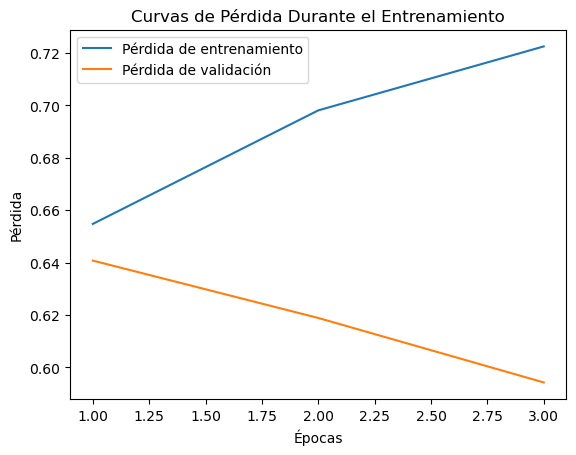

In [23]:

# Cargar el tokenizador y el modelo preentrenado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Suponiendo que 'texts' y 'labels' son tus datos
texts = ["text1", "text2", "text3"]  # Reemplazar con tus textos
labels = [0, 1, 0]  # Reemplazar con las etiquetas correspondientes

# Tokenización y preprocesamiento
train_encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# Convertir etiquetas a tipo numérico (si son de tipo 'object', 'str', etc.)
y_train = labels  # Si ya tienes los labels como lista
y_val = labels    # Si ya tienes los labels como lista
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)

# Crear datasets y dataloaders para entrenamiento y validación
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Inicializar las listas para almacenar las pérdidas
train_losses = []
val_losses = []

# Entrenamiento
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_val_loss = 0
    
    # Entrenamiento
    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    # Pérdida media de entrenamiento
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluación en validación
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    # Pérdida media de validación
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Entrenamiento - Pérdida: {avg_train_loss:.4f}")
    print(f"Validación - Pérdida: {avg_val_loss:.4f}")

# Visualización de las pérdidas
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Pérdida de entrenamiento')
plt.plot(epochs, val_losses, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curvas de Pérdida Durante el Entrenamiento')
plt.show()



## Ejercicio 2: Implementación de BERT

**Objetivo**: Construir y entrenar un modelo BERT para clasificar las noticias.

**Acciones**:

1. Utilizar la biblioteca transformers de Hugging Face para cargar el modelo BERT preentrenado.
2. Ajustar el modelo con el conjunto de datos de entrenamiento.
3. Evaluar el modelo utilizando un conjunto de datos de validación.

In [24]:

# Configurar el modelo para clasificación binaria
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Mover a GPU si está disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
# Asegurarte de que las etiquetas son tensores de PyTorch correctamente tipados
print("Tipo de datos de y_train:", y_train.dtype)  # Verifica el tipo de datos del tensor

# Muestra los primeros 5 valores del tensor
print("Primeros 5 valores de y_train:", y_train[:5])

# Si las etiquetas son categorías como 'positivo' y 'negativo', convertimos a números
# Supongamos que 'positivo' es 1 y 'negativo' es 0
y_train = torch.tensor([1 if label == 'positivo' else 0 for label in y_train])

# Convertir y_train a tensor de tipo long (int64)
y_train_tensor = y_train.long()  # Asegúrate de que las etiquetas son enteras

# Repetir el proceso para las etiquetas de validación (si las tienes)
# Suponiendo que y_val es tu conjunto de validación y sigue el mismo formato
y_val_tensor = torch.tensor([1 if label == 'positivo' else 0 for label in y_val])

# Ahora preparamos los datasets de PyTorch
from torch.utils.data import TensorDataset, DataLoader

# Preparar el dataset para entrenamiento y validación
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

# Cargar los datos en un DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)



Tipo de datos de y_train: torch.int64
Primeros 5 valores de y_train: tensor([0, 1, 0])


In [31]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='transformers')

In [32]:

# Configurar el optimizador
optimizer = AdamW(model.parameters(), lr=5e-5)

# Entrenar el modelo
for epoch in range(3):  # Ajusta el número de épocas según sea necesario
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()



## Ejercicio 3: Análisis de Resultados
**Objetivo**: Evaluar y comparar el rendimiento del modelo BERT.

**Acciones**:

Calcular métricas de rendimiento como precisión, recall y F1-score.
Visualizar las curvas de aprendizaje y los resultados de validación.
Comparar los resultados con los modelos RNN y LSTM implementados anteriormente.

In [ ]:

# Evaluar en el conjunto de validación
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        y_preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Reporte de clasificación
print(classification_report(y_true, y_preds))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Entrenamiento - Pérdida: 0.6042
Validación - Pérdida: 0.6211
Epoch 2/3
Entrenamiento - Pérdida: 0.6038
Validación - Pérdida: 0.6445
Epoch 3/3
Entrenamiento - Pérdida: 0.5958
Validación - Pérdida: 0.6071


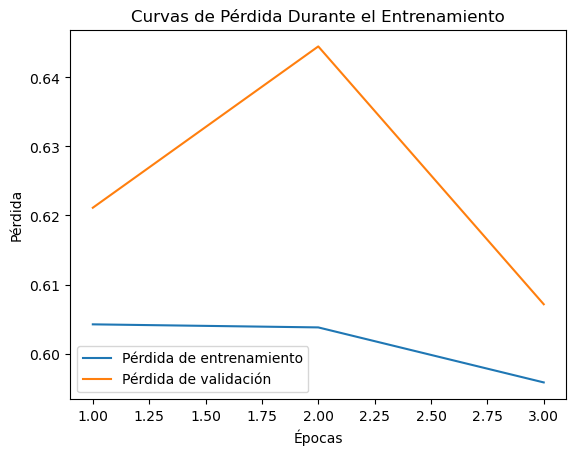

In [21]:
import torch
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Cargar el tokenizador y el modelo preentrenado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Suponiendo que 'texts' y 'labels' son tus datos
texts = ["text1", "text2", "text3"]  # Reemplazar con tus textos
labels = [0, 1, 0]  # Reemplazar con las etiquetas correspondientes

# Tokenización y preprocesamiento
inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# Crear datasets y dataloaders para entrenamiento y validación (reemplazar con tus datos)
train_encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

train_labels = torch.tensor(labels)
val_labels = torch.tensor(labels)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Inicializar las listas para almacenar las pérdidas
train_losses = []
val_losses = []

# Entrenamiento
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_val_loss = 0
    
    # Entrenamiento
    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    # Pérdida media de entrenamiento
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluación en validación
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    # Pérdida media de validación
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Entrenamiento - Pérdida: {avg_train_loss:.4f}")
    print(f"Validación - Pérdida: {avg_val_loss:.4f}")

# Visualización de las pérdidas
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Pérdida de entrenamiento')
plt.plot(epochs, val_losses, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curvas de Pérdida Durante el Entrenamiento')
plt.show()


## Ejercicio 4: Informe y Conclusiones

**Objetivo**: Documentar los resultados obtenidos y discutir las implicaciones prácticas.

**Acciones**:

Documentar los resultados obtenidos en un informe detallado, incluyendo gráficos y análisis de las métricas de rendimiento.
Discutir las implicaciones de los resultados para aplicaciones prácticas de NLP, como la automatización de la clasificación de noticias en sistemas de recomendación o análisis de medios.
Proponer posibles mejoras y futuras direcciones de investigación, como la exploración de arquitecturas híbridas o la integración de mecanismos de atención.